Setup the Keras Environment

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

Construct the Encoder

In [3]:
latent_dim = 10 #larger latent space

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z (Dense)                            │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,178 (270.23 KB)

 Trainable params: 69,178 (270.23 KB)

 Non-trainable params: 0 (0.00 B)

Construct the Decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

Define the AE as a Class with Custom Training

In [5]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction),#change error
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }
    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

Train the Model

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 59.5538 - reconstruction_loss: 59.5538
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 18.3340 - reconstruction_loss: 18.3340
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 14.4502 - reconstruction_loss: 14.4502
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 12.6480 - reconstruction_loss: 12.6480
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 11.7393 - reconstruction_loss: 11.7393
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 11.2342 - reconstruction_loss: 11.2342
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 10.8071 - reconstruction_loss: 10.8071
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.5512 - reconstruction_loss: 10.5512
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.2476 - reconstruction_loss: 10.2476
Epoch 10/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - l

In [7]:
print(history.history.keys())

dict_keys(['loss', 'reconstruction_loss'])


Plot the loss function

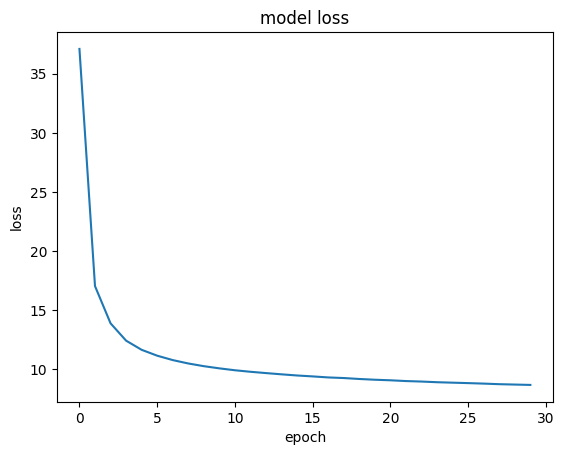

In [8]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


Save the Model Weights

Display a grid of sampled digits

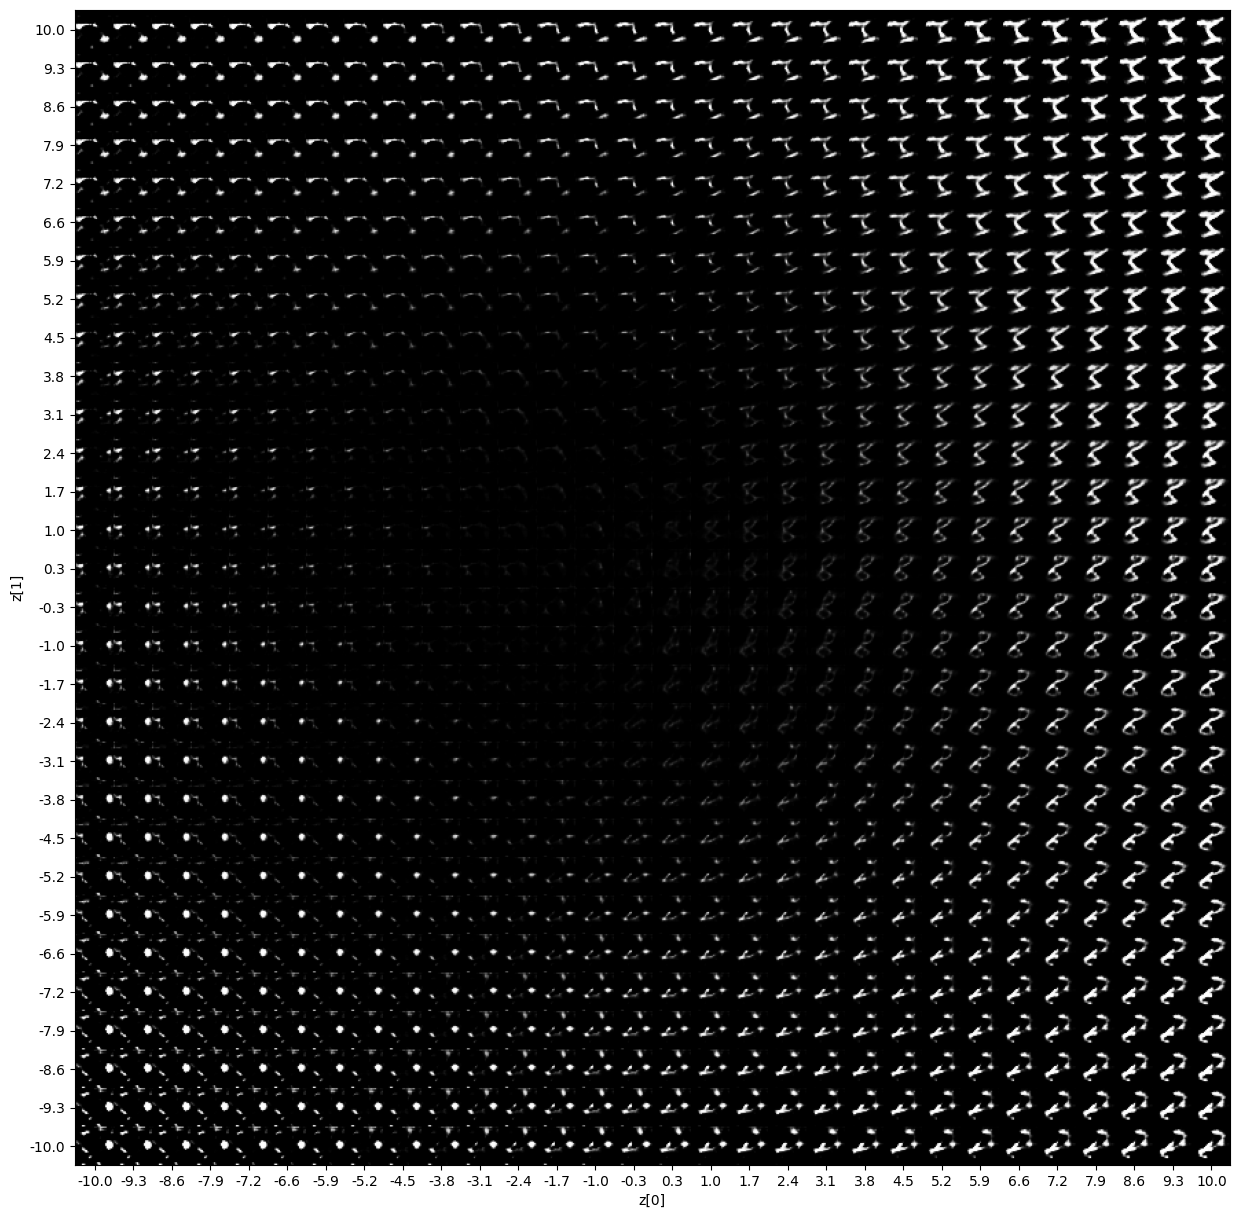

In [9]:
import matplotlib.pyplot as plt


def plot_latent_space(ae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 10.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi] + [0] * (latent_dim - 2)])
            x_decoded = ae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(ae)

Display how the latent space clusters different digit classes

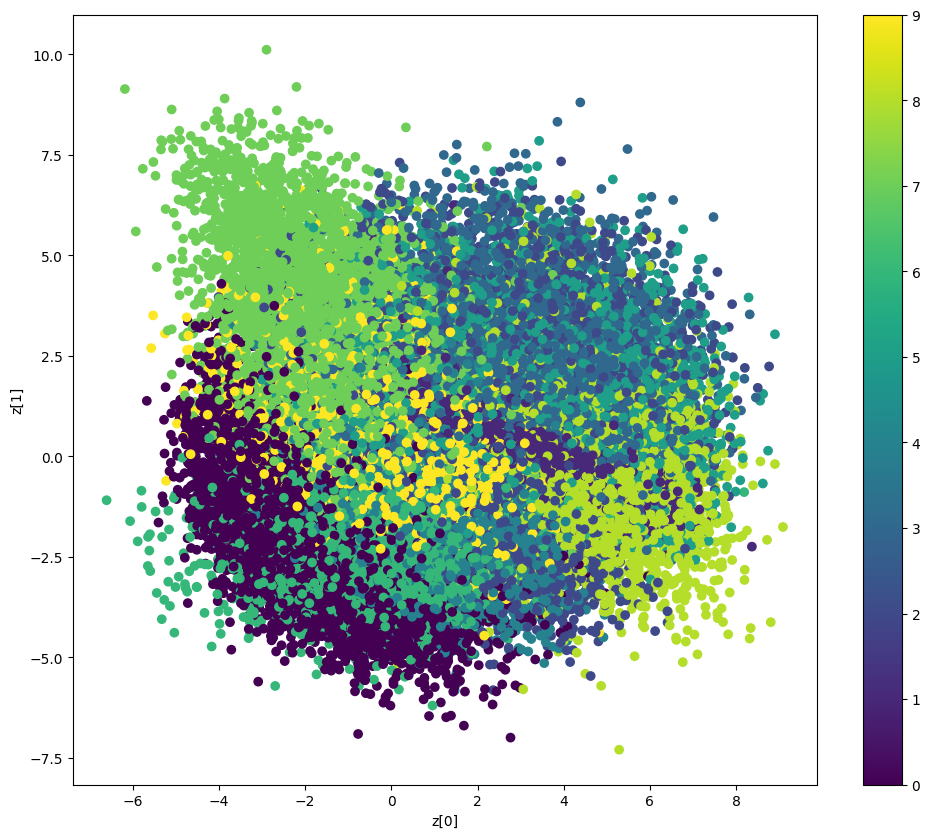

In [10]:
def plot_label_clusters(ae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = ae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(ae, x_train, y_train)

Inpainting

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


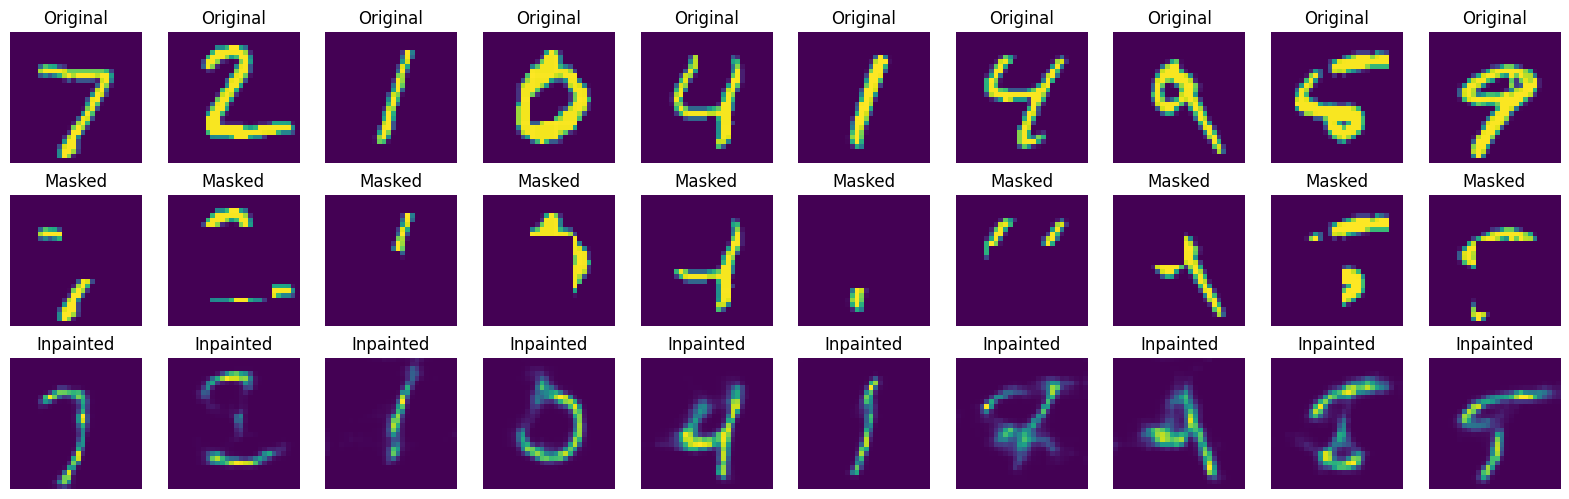

In [11]:
def create_masked_images(images, mask_size=5):
    masked_images = images.copy()
    masks = np.zeros_like(images)
    for img, mask in zip(masked_images, masks):
        x = np.random.randint(0, img.shape[0] - mask_size)
        y = np.random.randint(0, img.shape[1] - mask_size)
        img[x:x+mask_size, y:y+mask_size] = 0
        mask[x:x+mask_size, y:y+mask_size] = 1
    return masked_images, masks
mask_size = 15
x_train_masked, train_masks = create_masked_images(x_train, mask_size)
x_test_masked, test_masks = create_masked_images(x_test, mask_size)
xsmak=x_test_masked/255
n = 10
predicted_images = ae.predict(xsmak)
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Masked
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_masked[i])
    plt.title("Masked")
    plt.axis("off")

    # Inpainted
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predicted_images[i])
    plt.title("Inpainted")
    plt.axis("off")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


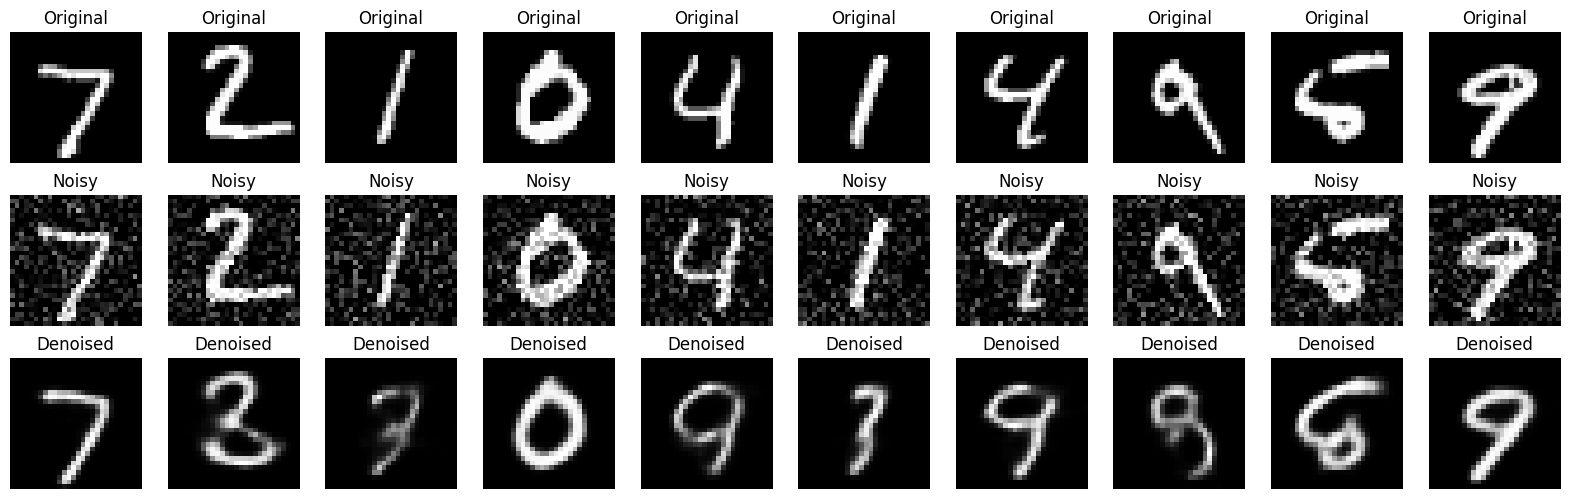

In [12]:
def create_noisy_images(images, noise_factor=0.5):
    noisy_images = images.copy()
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = noisy_images + noise_factor * noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noise_factor = 0.2
x_test_noisy = create_noisy_images(x_test / 255.0, noise_factor)

n = 10
predicted_images = ae.predict(x_test_noisy)
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i], cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.title("Denoised")
    plt.axis("off")
plt.show()

In [13]:
(x_trainfas, _), (x_testfas, _)=keras.datasets.fashion_mnist.load_data()
single_image = x_trainfas[0]
print(single_image.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(28, 28)


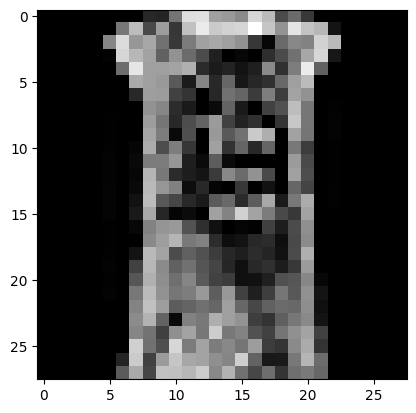

In [14]:
single_image = x_trainfas[550]
plt.imshow(single_image, cmap='gray')

In [15]:
sinim=single_image
single_image.shape

(28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


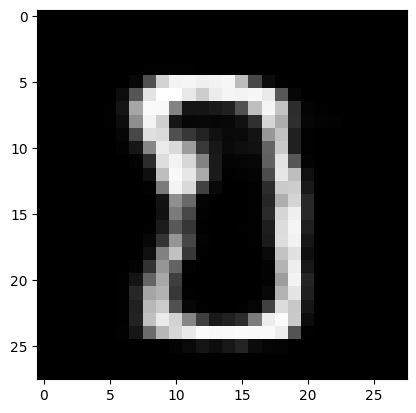

In [16]:
sinim = np.expand_dims(sinim, axis=0).astype("float32")/255  # Add channel dimension
predicted_fashion = ae.predict(sinim)
plt.imshow(predicted_fashion[0, :, :, 0], cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


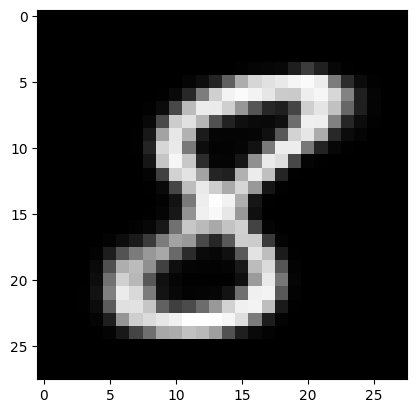

In [17]:
latentent = np.array([[6, 1, -2, 4, -2, 0.3, 0, 2, 0.2, 3]])
decoded_imgs = decoder.predict(latentent)
plt.imshow(decoded_imgs[0, :, :, 0], cmap='gray')
